In [1]:
from pathlib import Path

MLRUNS_DIR = Path().absolute().parents[1] / "mlruns"
MLRUNS_DIR

PosixPath('/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-ml/mlruns')

In [2]:
import mlflow

mlflow.set_tracking_uri(f"sqlite:///{MLRUNS_DIR}/mlflow.db")
mlflow.set_experiment("custom-layer")

<Experiment: artifact_location='/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/handson-ml/handson_ml/chapter_12/mlruns/1', creation_time=1698954400557, experiment_id='1', last_update_time=1698954400557, lifecycle_stage='active', name='custom-layer', tags={}>

In [3]:
from pathlib import Path
from time import strftime

PROJ_ROOT = Path().absolute()
MODEL_DIR = PROJ_ROOT / "models"
LOG_DIR = PROJ_ROOT / "logs"


def get_run_dir(root_dir, name="run"):
    return Path(root_dir) / f"{name}-{strftime('%Y_%m_%d-%H_%M_%S')}"

In [4]:
from tensorflow import keras

keras.utils.set_random_seed(42)
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

2023-11-04 13:51:08.942478: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 13:51:08.965773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Custom implementation of `LayerNormalization`

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model


@keras.saving.register_keras_serializable(package="CustomLayer")
class CustomLayerNormalization(keras.layers.Layer):
    def __init__(self, eps=10e-3, **kwargs):
        super().__init__(**kwargs)
        self._eps = eps

    def build(self, batch_input_shape):
        self._alpha = self.add_weight(
            shape=batch_input_shape[-1:], initializer="ones", name="alpha"
        )
        self._beta = self.add_weight(
            shape=batch_input_shape[-1:], initializer="zeros", name="beta"
        )

    def call(self, X):
        mean, var = tf.nn.moments(X, axes=-1, keepdims=True)
        return self._alpha * (X - mean) / tf.sqrt(var + self._eps) + self._beta

    def get_config(self):
        base_config = super().get_config()
        return base_config | {"eps": self._eps}

In [6]:
epochs = 100
batch_size = 128
val_split = 0.2
optimizer = "adam"
loss = "sparse_categorical_crossentropy"
run = "custom_layer"

mlflow.tensorflow.autolog()

custom_layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        CustomLayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        CustomLayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
custom_layernet.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

norm.adapt(X_train)
history = custom_layernet.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        # keras.callbacks.ModelCheckpoint(
        #     str(get_run_dir(MODEL_DIR, name=run)), patience=10, save_best_only=True
        # ),
        # keras.callbacks.TensorBoard(log_dir=str(get_run_dir(LOG_DIR, name=run))),
    ],
)

2023/11/04 13:51:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023-11-04 13:51:12.879770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 13:51:12.894831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 13:51:12.894942: I tensorflow/compiler/xla/stream_executor/cuda/c

Epoch 1/100


2023-11-04 13:51:14.831100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-04 13:51:14.846201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ffd5e80b640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 13:51:14.846225: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-04 13:51:14.848700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-04 13:51:14.854909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-11-04 13:51:14.911409: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

375/375 [==============================] - 2s 3ms/step - loss: 0.5608 - accuracy: 0.8111 - val_loss: 0.4127 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3726 - accuracy: 0.8680 - val_loss: 0.3747 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3310 - accuracy: 0.8812 - val_loss: 0.3583 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3024 - accuracy: 0.8909 - val_loss: 0.3418 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2821 - accuracy: 0.8964 - val_loss: 0.3385 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.9042 - val_loss: 0.3350 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 0

INFO:tensorflow:Assets written to: /tmp/nix-shell.GuNQ7r/tmpfv8neclu/model/data/model/assets
2023/11/04 13:51:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/twogoodap/Coding_Playground/Machine_Learning/Hands_on_Machine_Learning/.micromamba/envs/homl/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Verifying with the `keras` implementation of `LayerNormalization`

In [10]:
tf.reduce_mean(
    keras.metrics.mean_squared_error(
        keras.layers.LayerNormalization()(X_train.astype("float32")),
        CustomLayerNormalization()(X_train.astype("float32")),
    )
)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7628e-06>

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

epochs = 20
batch_size = 128
val_split = 0.2
optimizer = "adam"
loss = "sparse_categorical_crossentropy"
run = "custom_layer"

# mlflow.tensorflow.autolog()

layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
layernet.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

norm.adapt(X_train)
k_history = layernet.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
        # keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        # keras.callbacks.ModelCheckpoint(
        #     str(get_run_dir(MODEL_DIR, name=run)), patience=10, save_best_only=True
        # ),
        # keras.callbacks.TensorBoard(log_dir=str(get_run_dir(LOG_DIR, name=run))),
    ],
)

2023/11/04 14:34:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd7610c46af1248a0815d021f1abb44f3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20
  1/375 [..............................] - ETA: 4:17 - loss: 2.8661 - accuracy: 0.0938WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0010s vs `on_train_batch_end` time: 0.0015s). Check your callbacks.


375/375 [==============================] - 1s 2ms/step - loss: 0.5608 - accuracy: 0.8113 - val_loss: 0.4127 - val_accuracy: 0.8536
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3726 - accuracy: 0.8681 - val_loss: 0.3748 - val_accuracy: 0.8653
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3310 - accuracy: 0.8812 - val_loss: 0.3582 - val_accuracy: 0.8683
Epoch 4/20
375/375 [==============================] - 1s 1ms/step - loss: 0.3024 - accuracy: 0.8909 - val_loss: 0.3421 - val_accuracy: 0.8773
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2822 - accuracy: 0.8965 - val_loss: 0.3389 - val_accuracy: 0.8801
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2653 - accuracy: 0.9042 - val_loss: 0.3352 - val_accuracy: 0.8779
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2543 - accuracy: 0.9069 - val_loss: 0.3423 - val_accuracy: 0.8799
Epoch 8/20
375/37

INFO:tensorflow:Assets written to: /tmp/nix-shell.GuNQ7r/tmp1aumae6x/model/data/model/assets


In [54]:
k_history.history

{'loss': [0.5607707500457764,
  0.3726051151752472,
  0.3310036361217499,
  0.3024294078350067,
  0.2822059392929077,
  0.2652947008609772,
  0.25428110361099243,
  0.2389880120754242,
  0.2287013977766037,
  0.21906638145446777,
  0.20986120402812958,
  0.20031581819057465,
  0.19422847032546997,
  0.18816153705120087,
  0.17959119379520416,
  0.17462314665317535,
  0.16771699488162994,
  0.16340011358261108,
  0.15965190529823303,
  0.15441834926605225],
 'accuracy': [0.8112916946411133,
  0.8681250214576721,
  0.8812083601951599,
  0.890874981880188,
  0.8964999914169312,
  0.9041666388511658,
  0.9069374799728394,
  0.9129166603088379,
  0.9164583086967468,
  0.9193124771118164,
  0.9227916598320007,
  0.9256874918937683,
  0.9291458129882812,
  0.9304999709129333,
  0.9328333139419556,
  0.9349374771118164,
  0.9383958578109741,
  0.9401458501815796,
  0.9407291412353516,
  0.9433749914169312],
 'val_loss': [0.41270744800567627,
  0.3747940957546234,
  0.35820454359054565,
  0.342

## Custom training loop for Fashion MNIST

In [53]:
from sys import stdout

import tensorflow as tf
from tensorflow import keras
from tqdm import trange


def train(
    model,
    X,
    y,
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=None,
    epochs=20,
    batch_size=64,
    validation_split=None,
):
    def _print_status_bar(step, total, loss, metrics=None, val=False):
        metrics = " - ".join(
            [
                f"{metric.name}: {metric.result():.4f}"
                for metric in [loss] + (metrics or [])
            ]
        )
        end = "" if val or step < total else "\n"
        print(f"\r{step}/{total} - {metrics}", end=end)

    keras.utils.set_random_seed(42)
    optimizer = keras.optimizers.get(optimizer)
    loss = keras.losses.get(loss)
    mean = keras.metrics.Mean()
    metrics = metrics or [keras.metrics.SparseCategoricalAccuracy()]
    history = {"loss": []} | {m.name: [] for m in metrics}

    if validation_split is not None:
        val_idx = tf.cast(
            tf.math.ceil(y.shape[0] * validation_split), dtype=tf.int32
        ).numpy()
        X_valid, y_valid = X[-val_idx:], y[-val_idx:]
        X_train, y_train = X[:-val_idx], y[:-val_idx]
        val_batches = tf.cast(
            tf.math.ceil(y_valid.shape[0] / batch_size), dtype=tf.int32
        )

        history = history | {"val_loss": []} | {f"val_{m.name}": [] for m in metrics}
    else:
        X_train, y_train = X, y
    train_batches = tf.cast(tf.math.ceil(y_train.shape[0] / batch_size), dtype=tf.int32)

    for i in tf.range(epochs, dtype=tf.int32):
        train_idx = tf.random.shuffle(tf.range(y_train.shape[0]))
        X_train, y_train = X_train[train_idx], y_train[train_idx]
        print(f"Epoch {i + 1}/{epochs}")

        with trange(
            train_batches,
            dynamic_ncols=True,
            file=stdout,
            bar_format="{desc}{n_fmt}/{total_fmt} |{bar}| {elapsed}, {rate_fmt}{postfix}",
        ) as batches:
            for j in batches:
                X_batch, y_batch = (
                    tf.constant(X_train[j * batch_size : (j + 1) * batch_size]),
                    tf.constant(y_train[j * batch_size : (j + 1) * batch_size]),
                )

                with tf.GradientTape() as tape:
                    y_pred = model(X_batch, training=True)
                    loss_val = tf.add_n(
                        [tf.reduce_mean(loss(y_batch, y_pred))] + model.losses
                    )

                gradients = tape.gradient(loss_val, model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, model.trainable_weights))

                for var in model.variables:
                    if var.constraint is not None:
                        var.assign(var.constraint(var))

                mean(loss_val)
                for metric in metrics:
                    metric(y_batch, y_pred)

                batches.set_postfix(
                    {"loss": loss_val.numpy()}
                    | {f"{m.name.split('_')[-1]}": m.result().numpy() for m in metrics}
                )

        history["loss"].append(mean.result().numpy())
        mean.reset_states()
        for metric in metrics:
            history[metric.name].append(metric.result().numpy())
            metric.reset_states()

        if validation_split is not None:
            for j in tf.range(val_batches, dtype=tf.int32):
                X_batch, y_batch = (
                    tf.constant(
                        X_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                    tf.constant(
                        y_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                )
                y_pred = model(X_batch, training=False)

                mean(loss(y_batch, y_pred))
                for metric in metrics:
                    metric(y_batch, y_pred)

            print(
                f"val_loss={mean.result():.3f}, "
                + ", ".join(
                    [f"val_{m.name.split('_')[-1]}={m.result():.3f}" for m in metrics]
                )
            )

            history["val_loss"].append(mean.result().numpy())
            mean.reset_states()
            for metric in metrics:
                history[f"val_{metric.name}"].append(metric.result().numpy())
                metric.reset_states()

    return history

In [55]:
layernet = keras.Sequential(
    [
        (norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])),
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

norm.adapt(X_train)
history = train(layernet, X_train, y_train, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 87.45it/s, loss=0.494, accuracy=0.815
val_loss=0.422, val_accuracy=0.851
Epoch 2/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:03, 98.81it/s, loss=0.391, accuracy=0.869
val_loss=0.369, val_accuracy=0.868
Epoch 3/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:03, 99.21it/s, loss=0.442, accuracy=0.881
val_loss=0.353, val_accuracy=0.871
Epoch 4/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:03, 98.96it/s, loss=0.229, accuracy=0.892
val_loss=0.347, val_accuracy=0.873
Epoch 5/20
375/375 |█████████████████████████████████████████████████████████████████████████| 00:03, 102.01it/s, loss=0.2, accuracy=0.899
val_loss=0.338, val_accuracy=0.879
Epoch 6/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:03, 98.89it/s, loss=0.189, accura

In [57]:
history

{'loss': [0.54794514,
  0.37074178,
  0.32894757,
  0.2978979,
  0.27790016,
  0.26371083,
  0.2505905,
  0.2344725,
  0.22397825,
  0.21663043,
  0.2068878,
  0.19896443,
  0.19093262,
  0.18405426,
  0.1791344,
  0.17200157,
  0.16228774,
  0.15826127,
  0.15485215,
  0.15017694],
 'sparse_categorical_accuracy': [0.8146458,
  0.86920834,
  0.88091666,
  0.8920417,
  0.89858335,
  0.9035,
  0.9066667,
  0.9129792,
  0.91670835,
  0.9185625,
  0.92347914,
  0.9262292,
  0.92875,
  0.9339375,
  0.9345833,
  0.9375625,
  0.9406458,
  0.94177085,
  0.9433542,
  0.9439375],
 'val_loss': [0.42178726,
  0.36912382,
  0.35273033,
  0.3468162,
  0.33762968,
  0.34686264,
  0.3312627,
  0.34103706,
  0.3275309,
  0.35468233,
  0.33391917,
  0.34005484,
  0.36153784,
  0.3451724,
  0.3853222,
  0.36879465,
  0.36948666,
  0.3959131,
  0.3838208,
  0.3935409],
 'val_sparse_categorical_accuracy': [0.8509167,
  0.8678333,
  0.87058336,
  0.8735,
  0.87916666,
  0.87733334,
  0.8808333,
  0.8789167,

In [60]:
from sys import stdout

import tensorflow as tf
from tensorflow import keras
from tqdm import trange


def multi_train(
    model,
    X,
    y,
    layers,
    optimizers,
    loss="sparse_categorical_crossentropy",
    metrics=None,
    epochs=20,
    batch_size=64,
    validation_split=None,
):
    def _print_status_bar(step, total, loss, metrics=None, val=False):
        metrics = " - ".join(
            [
                f"{metric.name}: {metric.result():.4f}"
                for metric in [loss] + (metrics or [])
            ]
        )
        end = "" if val or step < total else "\n"
        print(f"\r{step}/{total} - {metrics}", end=end)

    keras.utils.set_random_seed(42)
    optimizers = [keras.optimizers.get(optim) for optim in optimizers]
    loss = keras.losses.get(loss)
    mean = keras.metrics.Mean()
    metrics = metrics or [keras.metrics.SparseCategoricalAccuracy()]
    history = {"loss": []} | {m.name: [] for m in metrics}

    if validation_split is not None:
        val_idx = tf.cast(
            tf.math.ceil(y.shape[0] * validation_split), dtype=tf.int32
        ).numpy()
        X_valid, y_valid = X[-val_idx:], y[-val_idx:]
        X_train, y_train = X[:-val_idx], y[:-val_idx]
        val_batches = tf.cast(
            tf.math.ceil(y_valid.shape[0] / batch_size), dtype=tf.int32
        )

        history = history | {"val_loss": []} | {f"val_{m.name}": [] for m in metrics}
    else:
        X_train, y_train = X, y
    train_batches = tf.cast(tf.math.ceil(y_train.shape[0] / batch_size), dtype=tf.int32)

    for i in tf.range(epochs, dtype=tf.int32):
        train_idx = tf.random.shuffle(tf.range(y_train.shape[0]))
        X_train, y_train = X_train[train_idx], y_train[train_idx]
        print(f"Epoch {i + 1}/{epochs}")

        with trange(
            train_batches,
            dynamic_ncols=True,
            file=stdout,
            bar_format="{desc}{n_fmt}/{total_fmt} |{bar}| {elapsed}, {rate_fmt}{postfix}",
        ) as batches:
            for j in batches:
                X_batch, y_batch = (
                    tf.constant(X_train[j * batch_size : (j + 1) * batch_size]),
                    tf.constant(y_train[j * batch_size : (j + 1) * batch_size]),
                )

                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch, training=True)
                    loss_val = tf.add_n(
                        [tf.reduce_mean(loss(y_batch, y_pred))] + model.losses
                    )

                for layer, optim in zip(layers, optimizers):
                    gradients = tape.gradient(loss_val, layer.trainable_weights)
                    optim.apply_gradients(zip(gradients, layer.trainable_weights))
                del tape

                for var in model.variables:
                    if var.constraint is not None:
                        var.assign(var.constraint(var))

                mean(loss_val)
                for metric in metrics:
                    metric(y_batch, y_pred)

                batches.set_postfix(
                    {"loss": loss_val.numpy()}
                    | {f"{m.name.split('_')[-1]}": m.result().numpy() for m in metrics}
                )

        history["loss"].append(mean.result().numpy())
        mean.reset_states()
        for metric in metrics:
            history[metric.name].append(metric.result().numpy())
            metric.reset_states()

        if validation_split is not None:
            for j in tf.range(val_batches, dtype=tf.int32):
                X_batch, y_batch = (
                    tf.constant(
                        X_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                    tf.constant(
                        y_valid[j.numpy() * batch_size : (j.numpy() + 1) * batch_size]
                    ),
                )
                y_pred = model(X_batch, training=False)

                mean(loss(y_batch, y_pred))
                for metric in metrics:
                    metric(y_batch, y_pred)

            print(
                f"val_loss={mean.result():.3f}, "
                + ", ".join(
                    [f"val_{m.name.split('_')[-1]}={m.result():.3f}" for m in metrics]
                )
            )

            history["val_loss"].append(mean.result().numpy())
            mean.reset_states()
            for metric in metrics:
                history[f"val_{metric.name}"].append(metric.result().numpy())
                metric.reset_states()

    return history

In [61]:
lower = keras.Sequential(
    [
        keras.layers.Flatten(),
        keras.layers.Dense(50, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
    ]
)
upper = keras.Sequential(
    [
        keras.layers.Dense(30, activation="swish", kernel_initializer="he_normal"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(10, activation="softmax"),
    ]
)
multi_layernet = keras.Sequential(
    [(norm := keras.layers.Normalization(input_shape=X_train.shape[-2:])), lower, upper]
)

norm.adapt(X_train)
m_history = multi_train(
    multi_layernet,
    X_train,
    y_train,
    layers=(lower, upper),
    optimizers=("adam", "sgd"),
    batch_size=128,
    validation_split=0.2,
)

Epoch 1/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 76.03it/s, loss=0.549, accuracy=0.806
val_loss=0.462, val_accuracy=0.843
Epoch 2/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 81.86it/s, loss=0.394, accuracy=0.863
val_loss=0.393, val_accuracy=0.864
Epoch 3/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 83.47it/s, loss=0.434, accuracy=0.876
val_loss=0.372, val_accuracy=0.870
Epoch 4/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 84.10it/s, loss=0.256, accuracy=0.885
val_loss=0.358, val_accuracy=0.874
Epoch 5/20
375/375 |████████████████████████████████████████████████████████████████████████| 00:04, 83.20it/s, loss=0.235, accuracy=0.892
val_loss=0.347, val_accuracy=0.879
Epoch 6/20
375/375 |█████████████████████████████████████████████████████████████████████████| 00:04, 82.89it/s, loss=0.21, accura

In [62]:
m_history

{'loss': [0.60703707,
  0.40534887,
  0.3596817,
  0.3293681,
  0.30864352,
  0.292953,
  0.28005394,
  0.26529106,
  0.25399086,
  0.24423768,
  0.23628816,
  0.22900108,
  0.22081566,
  0.2133352,
  0.20757389,
  0.19996953,
  0.19452111,
  0.19031584,
  0.18478149,
  0.18053314],
 'sparse_categorical_accuracy': [0.80558336,
  0.8629792,
  0.8759583,
  0.8852083,
  0.8918125,
  0.89720833,
  0.9008125,
  0.90672916,
  0.91075,
  0.9128125,
  0.91627085,
  0.92029166,
  0.92258334,
  0.92527086,
  0.926875,
  0.9298958,
  0.93214583,
  0.9333125,
  0.9347917,
  0.937125],
 'val_loss': [0.46192932,
  0.39269677,
  0.3719622,
  0.35817844,
  0.34674686,
  0.35264957,
  0.34525698,
  0.34364545,
  0.33506247,
  0.33387253,
  0.33386374,
  0.33342674,
  0.33412763,
  0.3294246,
  0.34057006,
  0.34094432,
  0.34108672,
  0.34184954,
  0.3406513,
  0.34951758],
 'val_sparse_categorical_accuracy': [0.84291667,
  0.86408335,
  0.87008333,
  0.8743333,
  0.87883335,
  0.87675,
  0.8775833,
  

In [64]:
import cudf as cd

khist = cd.DataFrame(k_history.history)
hist = cd.DataFrame(history)
hist.columns = khist.columns
mhist = cd.DataFrame(m_history)
mhist.columns = khist.columns

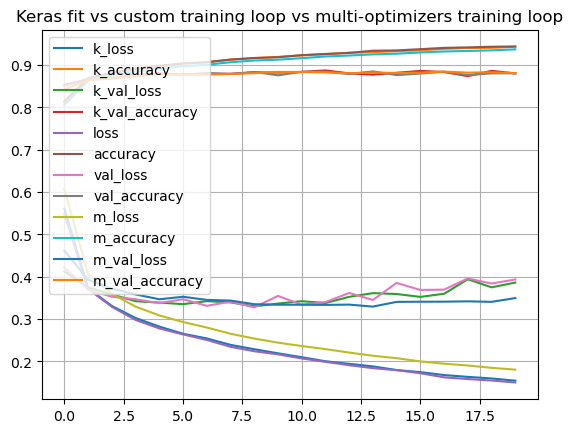

In [69]:
ax = khist.rename(columns=lambda c: f"k_{c}").to_pandas().plot()
hist.to_pandas().plot(ax=ax)
mhist.rename(columns=lambda c: f"m_{c}").to_pandas().plot(ax=ax)
ax.grid(True)
ax.legend(loc="upper left")
ax.set_title("Keras fit vs custom training loop vs multi-optimizers training loop");